In [15]:
#Import packages
import numpy as np
from grove.pyqaoa.maxcut_qaoa import maxcut_qaoa

#New way (Pyquil 2)
from pyquil.api import WavefunctionSimulator

#Old way
#import pyquil.api as api
#Connect to QVM
#qvm_connection = api.QVMConnection()

In [16]:
#Define the graph on which to run MAX-CUT 
square_ring = [(0,1),(1,2),(2,3),(3,0)]

#My code for weighting
weight = 2
srDict = dict(square_ring)
for v,e in srDict.items():
       e = e*weight
       sr_weighted = (v,e)
       sr = [(v,e)]
       print(sr)

[(0, 2)]
[(1, 4)]
[(2, 6)]
[(3, 0)]


In [17]:
#Istantiate the algorithm;
#Run the optimization routine on QVM
steps = 2
inst = maxcut_qaoa(graph=sr, steps=steps, samples=2)
#Betas, gammas
bg = inst.get_angles()

	Parameters: [1.34010833 2.25078392 1.95575595 2.30399665] 
	E => -0.5
	Parameters: [1.34010833 2.25078392 1.95575595 2.30399665] 
	E => -1.0
	Parameters: [1.34010833 2.25078392 1.95575595 2.30399665] 
	E => -1.0
	Parameters: [1.34010833 2.25078392 1.95575595 2.30399665] 
	E => -0.5
	Parameters: [1.34010833 2.25078392 1.95575595 2.30399665] 
	E => -1.0
	Parameters: [1.34010833 2.25078392 1.95575595 2.30399665] 
	E => -1.0
	Parameters: [1.34010833 2.25078392 1.95575595 2.30399665] 
	E => -1.0
	Parameters: [1.34010833 2.25078392 1.95575595 2.30399665] 
	E => -0.5
	Parameters: [1.34010833 2.25078392 1.95575595 2.30399665] 
	E => -1.0
	Parameters: [1.34010833 2.25078392 1.95575595 2.30399665] 
	E => -1.0
	Parameters: [1.34010833 2.25078392 1.95575595 2.30399665] 
	E => -1.0
	Parameters: [1.34010833 2.25078392 1.95575595 2.30399665] 
	E => -1.0
	Parameters: [1.34010833 2.25078392 1.95575595 2.30399665] 
	E => -0.5
	Parameters: [1.34010833 2.25078392 1.95575595 2.30399665] 
	E => -1.0
	Param

In [31]:
#To see the final |Beta, gamma> state we can rebuild the quil program that gives us |Beta, gamma> and evaluate the wave function using the QVM
t = np.hstack((bg))
param_prog = inst.get_parameterized_program()
prog = param_prog(t)

#New way
wf = WavefunctionSimulator().wavefunction(prog)
wf = wf.amplitudes
print(wf)

#Old way
#wf = qvm_connection.wavefunction(prog)
#wf = wf.amplitudes

[ 0.38491079-0.01224729j -0.08810101+0.58645708j -0.08810101+0.58645708j
  0.38491079-0.01224729j]


In [22]:
#wf is now a numpy array of complex-valued amplitudes for each computational basis state. To visualize the distribution iterate over the states and calculate the probability.
for state_index in range(inst.nstates):
    print(inst.states[state_index], np.conj(wf*[state_index])*(wf*[state_index]))

00 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
01 [0.14830631+0.j 0.35169369+0.j 0.35169369+0.j 0.14830631+0.j]
10 [0.59322524+0.j 1.40677476+0.j 1.40677476+0.j 0.59322524+0.j]
11 [1.3347568+0.j 3.1652432+0.j 3.1652432+0.j 1.3347568+0.j]


In [ ]:
#In the cells below, attempting to figure out noise.
#This is just a copy of the code in the docs at the moment.
#I'm stuck on this piece.

In [41]:
import matplotlib.pyplot as plt
from scipy.stats import binom
import matplotlib.colors as colors
%matplotlib inline

In [42]:
from pyquil import Program, get_qc
from pyquil.gates import CZ, H, I, X, MEASURE
from scipy.linalg import expm

In [43]:
# We could ask for "2q-noisy-qvm" but we will be specifying
# our noise model as PRAGMAs on the Program itself.
qc = get_qc('2q-qvm')

In [44]:
def damping_channel(damp_prob=.1):
    """
    Generate the Kraus operators corresponding to an amplitude damping
    noise channel.

    :params float damp_prob: The one-step damping probability.
    :return: A list [k1, k2] of the Kraus operators that parametrize the map.
    :rtype: list
    """
    damping_op = np.sqrt(damp_prob) * np.array([[0, 1],
                                                [0, 0]])

    residual_kraus = np.diag([1, np.sqrt(1-damp_prob)])
    return [residual_kraus, damping_op]

def append_kraus_to_gate(kraus_ops, g):
    """
    Follow a gate `g` by a Kraus map described by `kraus_ops`.

    :param list kraus_ops: The Kraus operators.
    :param numpy.ndarray g: The unitary gate.
    :return: A list of transformed Kraus operators.
    """
    return [kj.dot(g) for kj in kraus_ops]


def append_damping_to_gate(gate, damp_prob=.1):
    """
    Generate the Kraus operators corresponding to a given unitary
    single qubit gate followed by an amplitude damping noise channel.

    :params np.ndarray|list gate: The 2x2 unitary gate matrix.
    :params float damp_prob: The one-step damping probability.
    :return: A list [k1, k2] of the Kraus operators that parametrize the map.
    :rtype: list
    """
    return append_kraus_to_gate(damping_channel(damp_prob), gate)


In [45]:
%%time

# single step damping probability
damping_per_I = 0.02

# number of program executions
trials = 200

results_damping = []
lengths = np.arange(0, 201, 10, dtype=int)
for jj, num_I in enumerate(lengths):
    print("\r{}/{}, ".format(jj, len(lengths)), end="")


    p = Program(X(0))
    # want increasing number of I-gates
    p.inst([I(0) for _ in range(num_I)])
    p.inst(MEASURE(0, 0))

    # overload identity I on qc 0
    p.define_noisy_gate("I", [0], append_damping_to_gate(np.eye(2), damping_per_I))
    p.wrap_in_numshots_loop(trials)
    qc.qam.random_seed = int(num_I)
    res = qc.run(p)
    results_damping.append([np.mean(res), np.std(res) / np.sqrt(trials)])

results_damping = np.array(results_damping)

0/21, 

/Users/Yogesh/Desktop/Anaconda/anaconda3/envs/pyquil/lib/python3.7/site-packages/pyquil/gates.py:557: UserWarning: Indexing measurement addresses by integers is deprecated. Replacing this with the MemoryReference ro[i] instead.
  "Indexing measurement addresses by integers is deprecated. "
/Users/Yogesh/Desktop/Anaconda/anaconda3/envs/pyquil/lib/python3.7/site-packages/pyquil/quil.py:979: UserWarning: Please DECLARE all memory. I'm adding a declaration for the `ro` register, but I won't do this for you in the future.
  "Please DECLARE all memory. I'm adding a declaration for the `ro` register, "


20/21, CPU times: user 165 ms, sys: 24.5 ms, total: 189 ms
Wall time: 6.15 s


In [47]:
dense_lengths = np.arange(0, lengths.max()+1, .2)
survival_probs = (1-damping_per_I)**dense_lengths
logpmf = binom.logpmf(np.arange(trials+1)[np.newaxis, :], trials, survival_probs[:, np.newaxis])/np.log(10)

In [48]:
DARK_TEAL = '#48737F'
FUSCHIA = "#D6619E"
BEIGE = '#EAE8C6'
cm = colors.LinearSegmentedColormap.from_list('anglemap', ["white", FUSCHIA, BEIGE], N=256, gamma=1.5)

(0, 1)

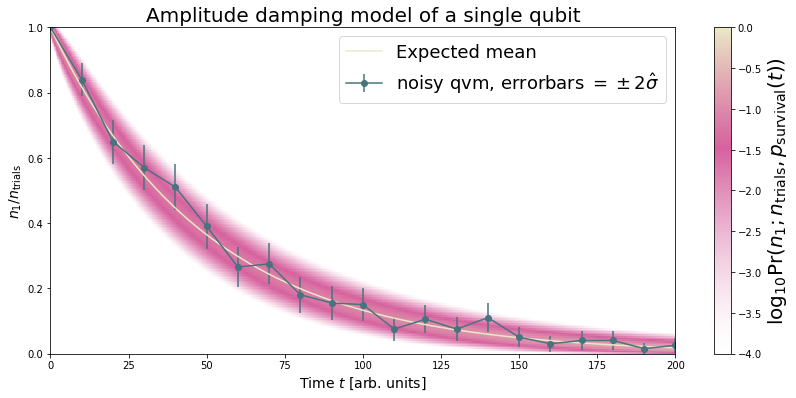

In [49]:
plt.figure(figsize=(14, 6))
plt.pcolor(dense_lengths, np.arange(trials+1)/trials, logpmf.T, cmap=cm, vmin=-4, vmax=logpmf.max())
plt.plot(dense_lengths, survival_probs, c=BEIGE, label="Expected mean")
plt.errorbar(lengths, results_damping[:,0], yerr=2*results_damping[:,1], c=DARK_TEAL,
             label=r"noisy qvm, errorbars $ = \pm 2\hat{\sigma}$", marker="o")
cb = plt.colorbar()
cb.set_label(r"$\log_{10} \mathrm{Pr}(n_1; n_{\rm trials}, p_{\rm survival}(t))$", size=20)

plt.title("Amplitude damping model of a single qubit", size=20)
plt.xlabel(r"Time $t$ [arb. units]", size=14)
plt.ylabel(r"$n_1/n_{\rm trials}$", size=14)
plt.legend(loc="best", fontsize=18)
plt.xlim(*lengths[[0, -1]])
plt.ylim(0, 1)